In [2]:
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

# LOAD AND CLEAN DATA
cal = pd.read_csv("wildfires.csv").drop(["_id", "OBJECTID", "APN (parcel)", "x", "y"], axis=1)
cal["Incident Start Date"] = pd.to_datetime(cal["Incident Start Date"])
cal["Day"] = cal["Incident Start Date"].dt.day
cal["Month"] = cal["Incident Start Date"].dt.month
cal["Year"] = cal["Incident Start Date"].dt.year
cal["* City"] = cal["* City"].fillna("Non-city")
fires = cal.query("County == 'San Diego'")
cat_cols = ["* Street Type (e.g. road, drive, lane, etc.)", "* City", "County", "* Structure Type",
            "Structure Category", "* Roof Construction", "* Eaves", "* Vent Screen", "* Exterior Siding",
            "* Window Pane", "* Deck/Porch On Grade", "* Deck/Porch Elevated",
            "* Patio Cover/Carport Attached to Structure", "* Fence Attached to Structure"]
num_cols = ["Year Built (parcel)", "Latitude", "Longitude", "Month", "Year"]

# INITIAL MODEL
preproc = ColumnTransformer(
    transformers = [
        ("categorical", OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ("numerical", "passthrough", num_cols)
    ],
    remainder="drop"
)

data = fires[cat_cols + num_cols + ["Day", "* Damage"]].dropna()
X_train, X_test, y_train, y_test = (
    train_test_split(data[cat_cols + num_cols], data["* Damage"], test_size=0.25, random_state=1)
)
processing = Pipeline([("preproc", preproc), ("tree", RandomForestClassifier())])
processing.fit(X_train, y_train)
processing.score(X_test, y_test) # 0.8832116788321168

# DATAFRAMES OF VARIABLES
cols = []
curr = []
for c in cat_cols:
    curr = list(np.unique(data[c]))
    if "Unknown" in curr:
        curr[curr.index("Unknown")] = f"Unknown {c}"
    cols += curr[1:]
    curr = []
cols += num_cols
vars = pd.DataFrame(preproc.fit_transform(data).toarray()).rename(columns={x:cols[x] for x in range(69)})

cal_data = cal[cat_cols + num_cols + ["* Damage"]].dropna()
cols = []
curr = []
for c in cat_cols:
    curr = list(np.unique(cal_data[c]))
    cols += [f"{x} {c}" for x in curr][1:]
    curr = []
cols += num_cols
calv = pd.DataFrame(preproc.fit_transform(cal_data).toarray()).rename(columns={x:cols[x] for x in range(385)})
fit_cal = RandomForestClassifier().fit(calv, cal_data["* Damage"])

# HEATMAPS
sev_to_num = {
    'Destroyed (>50%)': 4,
    'Major (26-50%)': 3,
    'Minor (10-25%)': 2,
    'Affected (1-9%)': 1,
    'No Damage': 0,
    'Inaccessible': np.nan
}
heat = pd.DataFrame()
heat["Longitude"] = pd.qcut(data["Longitude"], 10)
heat["Latitude"] = pd.qcut(data["Latitude"], 10)
heat["Day"] = data["Day"]
heat["Month"] = data["Month"]
heat["Year"] = data["Year"]
heat["Damage"] = data["* Damage"].apply(lambda d: sev_to_num[d])
heatmap_num = pd.pivot_table(heat, index="Latitude", columns="Longitude", values="Damage", aggfunc="count").sort_index(ascending=False).replace(0, np.nan)
heatmap_sev = pd.pivot_table(heat, index="Latitude", columns="Longitude", values="Damage", aggfunc="mean").sort_index(ascending=False)
heattime_num = pd.pivot_table(heat, index="Year", columns="Month", values="Damage", aggfunc="count").sort_index(ascending=False).replace(0, np.nan)
heattime_sev = pd.pivot_table(heat, index="Year", columns="Month", values="Damage", aggfunc="mean").sort_index(ascending=False)

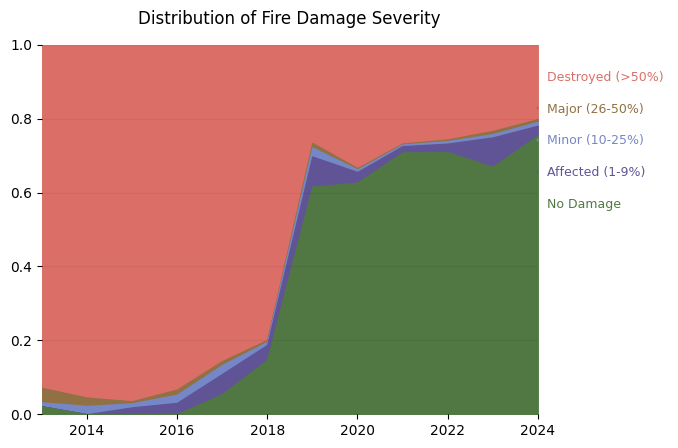

In [4]:
# TRANSFORMING DATA
cal["Score"] = cal["* Damage"].apply(lambda x: sev_to_num[x])
time_sev = (cal.groupby(["Year", "Score"])["State"].count()/cal.groupby(["Year"])["State"].count()).reset_index()
all_0 = (time_sev.query("Score <= 0.0").groupby("Year").sum()["State"] - pd.Series([0] * 12, index=np.unique(time_sev["Year"]))).fillna(0)
all_1 = (time_sev.query("Score <= 1.0").groupby("Year").sum()["State"] - pd.Series([0] * 12, index=np.unique(time_sev["Year"]))).fillna(0)
all_2 = (time_sev.query("Score <= 2.0").groupby("Year").sum()["State"] - pd.Series([0] * 12, index=np.unique(time_sev["Year"]))).fillna(0)
all_3 = (time_sev.query("Score <= 3.0").groupby("Year").sum()["State"] - pd.Series([0] * 12, index=np.unique(time_sev["Year"]))).fillna(0)
all_4 = (time_sev.query("Score <= 4.0").groupby("Year").sum()["State"] - pd.Series([0] * 12, index=np.unique(time_sev["Year"]))).fillna(0)

# PLOTTING DATA
colors = ["#db6f67", "#917144", "#7587c7", "#615496", "#517842"]
plt.fill_between(np.unique(time_sev["Year"]), color=colors[0], y1=all_3/all_4, y2=all_4/all_4, label=list(sev_to_num)[0])
plt.fill_between(np.unique(time_sev["Year"]), color=colors[1], y1=all_2/all_4, y2=all_3/all_4, label=list(sev_to_num)[1])
plt.fill_between(np.unique(time_sev["Year"]), color=colors[2], y1=all_1/all_4, y2=all_2/all_4, label=list(sev_to_num)[2])
plt.fill_between(np.unique(time_sev["Year"]), color=colors[3], y1=all_0/all_4, y2=all_1/all_4, label=list(sev_to_num)[3])
plt.fill_between(np.unique(time_sev["Year"]), color=colors[4], y1=0, y2=all_0/all_4, label=list(sev_to_num)[4])

# GRAPH STYLING
plt.title("Distribution of Fire Damage Severity", pad=15.0)
plt.xlim([2013, 2024])
plt.ylim([0, 1])
plt.grid(axis="y", fillstyle="full", color="black", alpha=0.05)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.legend(framealpha=.90, bbox_to_anchor=(1.276, 0.96), fontsize=9, handlelength=0, handleheight=0, labelspacing=1.5, frameon=False, labelcolor=colors)
plt.show()

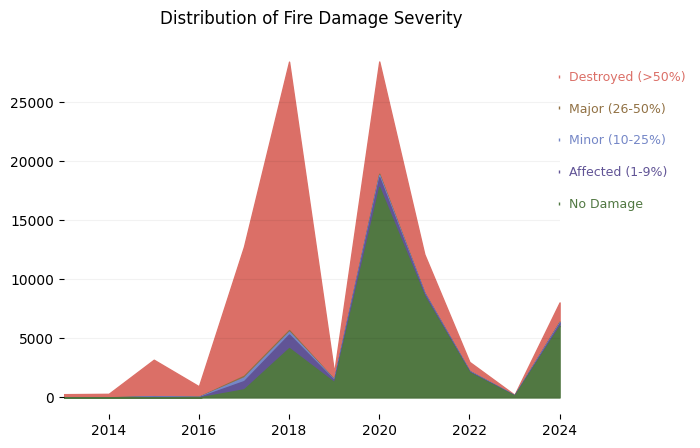

In [6]:
# TRANSFORMING DATA
cal["Score"] = cal["* Damage"].apply(lambda x: sev_to_num[x])
# time_sev = (cal.groupby(["Year", "Score"])["State"].count()/cal.groupby(["Year"])["State"].count()).reset_index()
time_sev = (cal.groupby(["Year", "Score"])["State"].count()).reset_index()
all_0 = (time_sev.query("Score <= 0.0").groupby("Year").sum()["State"] - pd.Series([0] * 12, index=np.unique(time_sev["Year"]))).fillna(0)
all_1 = (time_sev.query("Score <= 1.0").groupby("Year").sum()["State"] - pd.Series([0] * 12, index=np.unique(time_sev["Year"]))).fillna(0)
all_2 = (time_sev.query("Score <= 2.0").groupby("Year").sum()["State"] - pd.Series([0] * 12, index=np.unique(time_sev["Year"]))).fillna(0)
all_3 = (time_sev.query("Score <= 3.0").groupby("Year").sum()["State"] - pd.Series([0] * 12, index=np.unique(time_sev["Year"]))).fillna(0)
all_4 = (time_sev.query("Score <= 4.0").groupby("Year").sum()["State"] - pd.Series([0] * 12, index=np.unique(time_sev["Year"]))).fillna(0)

# PLOTTING DATA
colors = ["#db6f67", "#917144", "#7587c7", "#615496", "#517842"]
plt.fill_between(np.unique(time_sev["Year"]), color=colors[0], y1=all_3/1, y2=all_4/1, label=list(sev_to_num)[0])
plt.fill_between(np.unique(time_sev["Year"]), color=colors[1], y1=all_2/1, y2=all_3/1, label=list(sev_to_num)[1])
plt.fill_between(np.unique(time_sev["Year"]), color=colors[2], y1=all_1/1, y2=all_2/1, label=list(sev_to_num)[2])
plt.fill_between(np.unique(time_sev["Year"]), color=colors[3], y1=all_0/1, y2=all_1/1, label=list(sev_to_num)[3])
plt.fill_between(np.unique(time_sev["Year"]), color=colors[4], y1=0, y2=all_0/1, label=list(sev_to_num)[4])

# GRAPH STYLING
plt.title("Distribution of Fire Damage Severity", pad=15.0)
plt.xlim([2013, 2024])
# plt.ylim([0, 1])
plt.grid(axis="y", fillstyle="full", color="black", alpha=0.05)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.legend(framealpha=.90, bbox_to_anchor=(1.276, 0.96), fontsize=9, handlelength=0, handleheight=0, labelspacing=1.5, frameon=False, labelcolor=colors)
plt.show()

In [7]:
heattime_sev

Month,7,8,9
Year,,,
2023,NaN,3.000000,NaN
2022,NaN,0.901639,NaN
2020,NaN,NaN,0.789625
2018,3.516667,NaN,NaN


In [18]:
np.array([245, 71, 2])/255

array([0.96078431, 0.27843137, 0.00784314])

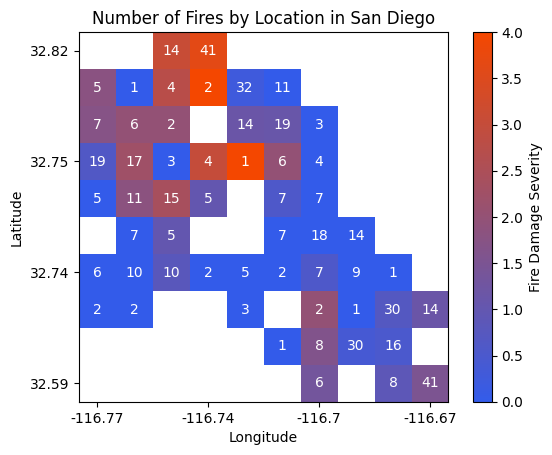

In [27]:
colors_list = [(0.2, 0.36, 0.92), (0.96, 0.28, 0)]
cmap = LinearSegmentedColormap.from_list("fire_colors", colors_list, N=1000)

plt.imshow(heatmap_sev, cmap=cmap)
for i in range(10): 
    for j in range(10): 
        plt.annotate(str(np.round(heatmap_num.iloc[i, j], 2))[:-2], xy=(j, i), 
                     ha='center', va='center', color='white') 

plt.title("Number of Fires by Location in San Diego")
plt.colorbar(label="Fire Damage Severity")
plt.xticks(range(10)[::3], [float(c.split(",")[0][1:8]) for c in heatmap_num.columns.astype(str)][::3])
plt.xlabel("Longitude")
plt.yticks(range(10)[::3], [float(c.split(",")[0][1:6]) for c in heatmap_num.index.astype(str)][::3])
plt.ylabel("Latitude")
plt.show()

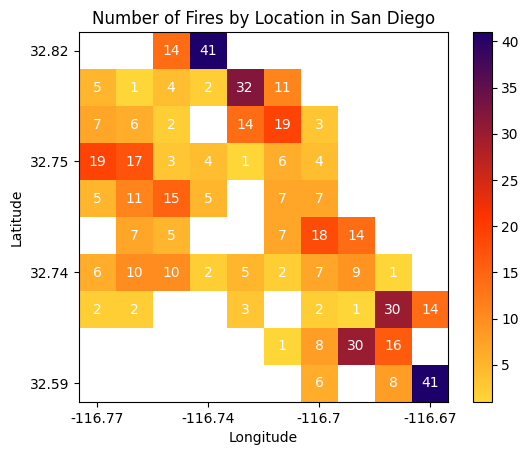

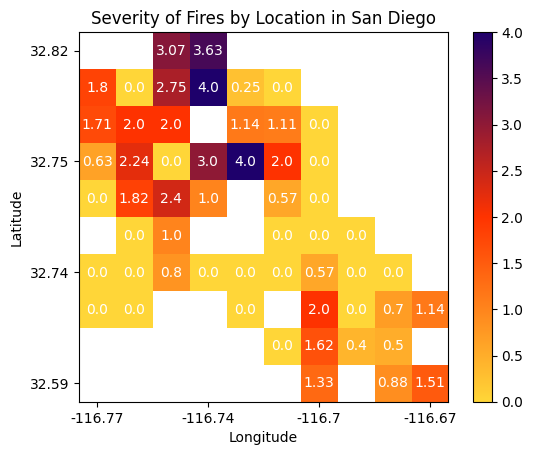

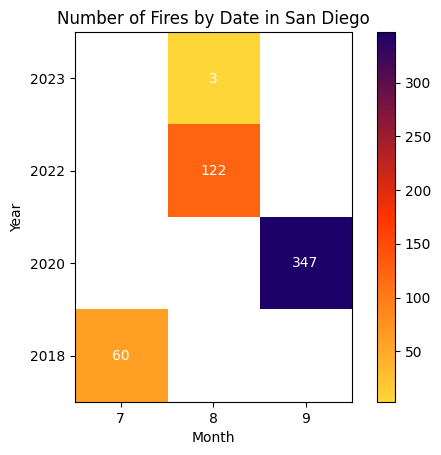

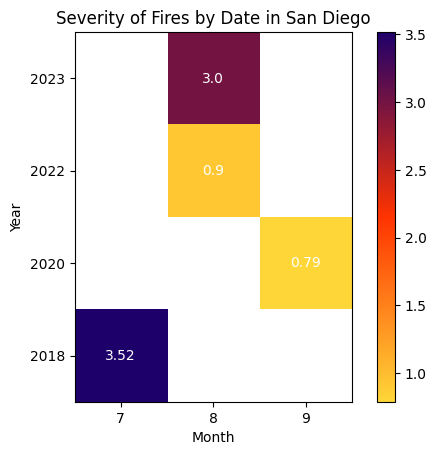

In [8]:
colors_list = [(1, 0.84, 0.22), (1, 0.2, 0), (0.12, 0, 0.42)]
cmap = LinearSegmentedColormap.from_list("fire_colors", colors_list, N=1000)
# cmap = matplotlib.colors.ListedColormap(colors_list)

plt.imshow(heatmap_num, cmap=cmap) 
for i in range(10): 
    for j in range(10): 
        plt.annotate(str(heatmap_num.iloc[i, j])[:-2], xy=(j, i), 
                     ha='center', va='center', color='white') 

plt.title("Number of Fires by Location in San Diego")
plt.colorbar()
plt.xticks(range(10)[::3], [float(c.split(",")[0][1:8]) for c in heatmap_num.columns.astype(str)][::3])
plt.xlabel("Longitude")
plt.yticks(range(10)[::3], [float(c.split(",")[0][1:6]) for c in heatmap_num.index.astype(str)][::3])
plt.ylabel("Latitude")
plt.show()

print()

plt.imshow(heatmap_sev, cmap=cmap) 
for i in range(10): 
    for j in range(10): 
        plt.annotate(str(np.round(heatmap_sev.iloc[i, j], 2)), xy=(j, i), 
                     ha='center', va='center', color='white') 

plt.title("Severity of Fires by Location in San Diego")
plt.colorbar()
plt.xticks(range(10)[::3], [float(c.split(",")[0][1:8]) for c in heatmap_num.columns.astype(str)][::3])
plt.xlabel("Longitude")
plt.yticks(range(10)[::3], [float(c.split(",")[0][1:6]) for c in heatmap_num.index.astype(str)][::3])
plt.ylabel("Latitude")
plt.show()

print()

plt.imshow(heattime_num, cmap=cmap) 
for i in range(4): 
    for j in range(3): 
        plt.annotate(str(heattime_num.iloc[i, j])[:-2], xy=(j, i), 
                     ha='center', va='center', color='white') 

plt.title("Number of Fires by Date in San Diego")
plt.colorbar()
plt.xticks(range(3), heattime_num.columns.astype(str))
plt.xlabel("Month")
plt.yticks(range(4), heattime_num.index.astype(str))
plt.ylabel("Year")
plt.show()

print()

plt.imshow(heattime_sev, cmap=cmap) 
for i in range(4): 
    for j in range(3): 
        plt.annotate(str(np.round(heattime_sev.iloc[i, j], 2)), xy=(j, i), 
                     ha='center', va='center', color='white') 

plt.title("Severity of Fires by Date in San Diego")
plt.colorbar()
plt.xticks(range(3), heattime_num.columns.astype(str))
plt.xlabel("Month")
plt.yticks(range(4), heattime_num.index.astype(str))
plt.ylabel("Year")
plt.show()

In [ ]:
num_cols = 20
num_rows = num_cols

calh = pd.DataFrame()
calh["Longitude"] = pd.qcut(cal["Longitude"], num_cols)
calh["Latitude"] = pd.qcut(cal["Latitude"], num_cols)
calh["Day"] = cal["Day"]
calh["Month"] = cal["Month"]
calh["Year"] = cal["Year"]
calh["Damage"] = cal["* Damage"].apply(lambda d: sev_to_num[d])
cal_time = pd.pivot_table(calh, index="Year", columns="Month", values="Damage", aggfunc="count").sort_index(ascending=False).replace(0, np.nan)
cal_map = pd.pivot_table(calh, index="Latitude", columns="Longitude", values="Damage", aggfunc="mean").sort_index(ascending=False).replace(0, np.nan)
cal_num = pd.pivot_table(calh, index="Latitude", columns="Longitude", values="Damage", aggfunc="count").sort_index(ascending=False).replace(0, np.nan)

colors_list = [(1, 0.84, 0.22), (1, 0.2, 0), (0.12, 0, 0.42)]
cmap = LinearSegmentedColormap.from_list("fire_colors", colors_list, N=1000)
# cmap = matplotlib.colors.ListedColormap(colors_list)

plt.figure(figsize=(10, 10))
plt.imshow(cal_map, cmap=cmap) 
for i in range(num_cols): 
    for j in range(num_cols): 
        plt.annotate(str(cal_num.iloc[i, j])[:-2], xy=(j, i), 
                     ha='center', va='center', color='white', size=5) 

plt.title("Number of Fires by Location in California")
plt.colorbar()
plt.xticks(range(num_cols)[::9], [float(c.split(",")[0][1:8]) for c in cal_map.columns.astype(str)][::9])
plt.xlabel("Longitude")
plt.yticks(range(num_cols)[::9], [float(c.split(",")[0][1:6]) for c in cal_map.index.astype(str)][::9])
plt.ylabel("Latitude")
plt.show()

In [32]:
list(pd.Series(fit_cal.feature_importances_, index=calv.columns).sort_values(ascending=False).index)

['Latitude',
 'Year',
 'Longitude',
 'Unknown * Eaves',
 'Month',
 'Butte County',
 'Year Built (parcel)',
 'Unknown * Roof Construction',
 'Unknown * Fence Attached to Structure',
 'Wood * Exterior Siding',
 'Unknown * Exterior Siding',
 'Ignition Resistant * Exterior Siding',
 'Unenclosed * Eaves',
 'Unknown * Deck/Porch On Grade',
 'Non-city * City',
 'Unknown * Deck/Porch Elevated',
 'No Fence * Fence Attached to Structure',
 'Unknown * Vent Screen',
 'Stucco Brick Cement * Exterior Siding',
 'Unknown * Patio Cover/Carport Attached to Structure',
 'Unknown * Window Pane',
 'No Deck/Porch * Deck/Porch Elevated',
 'Single Pane * Window Pane',
 'No Patio Cover/Carport * Patio Cover/Carport Attached to Structure',
 'No Vents * Vent Screen',
 'Mesh Screen > 1/8"" * Vent Screen',
 'No Deck/Porch * Deck/Porch On Grade',
 'Metal * Roof Construction',
 'Los Angeles County',
 'Masonry/Concrete * Deck/Porch On Grade',
 'Road * Street Type (e.g. road, drive, lane, etc.)',
 'Single Family Resid

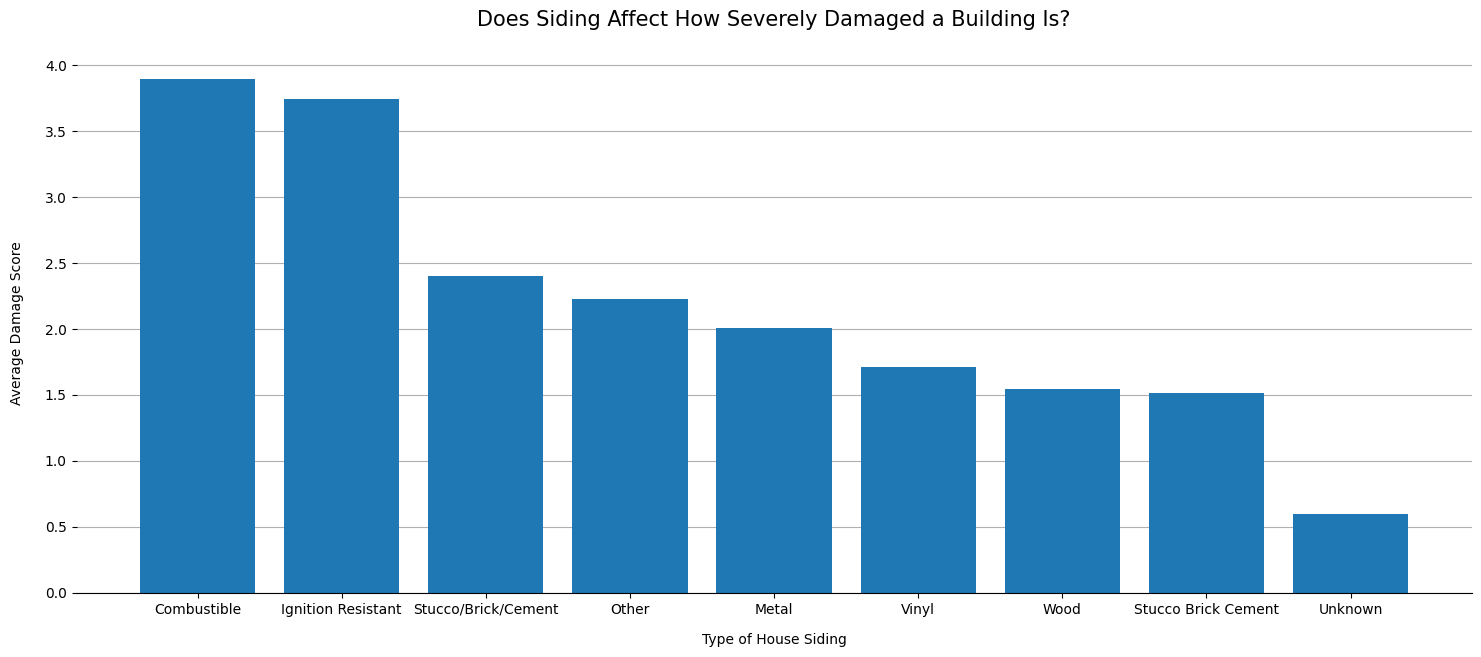

In [77]:
cal_data["Score"] = cal_data["* Damage"].apply(lambda d: sev_to_num[d])
siding = cal_data.groupby("* Exterior Siding")["Score"].mean().sort_values(ascending=False)

plt.figure(figsize=(18, 7))
plt.bar(x=siding.index, height=siding, zorder=2)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", zorder=1)
plt.title("Does Siding Affect How Severely Damaged a Building Is?", pad=20, size=15)
plt.ylabel("Average Damage Score", labelpad=15)
plt.xlabel("Type of House Siding", labelpad=12)
plt.show()

In [31]:
cal_data["* Damage"]

,"Alley * Street Type (e.g. road, drive, lane, etc.)","Avenue * Street Type (e.g. road, drive, lane, etc.)","Boulevard * Street Type (e.g. road, drive, lane, etc.)","Circle * Street Type (e.g. road, drive, lane, etc.)","Court * Street Type (e.g. road, drive, lane, etc.)","Drive * Street Type (e.g. road, drive, lane, etc.)","Hwy * Street Type (e.g. road, drive, lane, etc.)","Lane * Street Type (e.g. road, drive, lane, etc.)","Loop * Street Type (e.g. road, drive, lane, etc.)","Other * Street Type (e.g. road, drive, lane, etc.)",...,Non Combustible * Patio Cover/Carport Attached to Structure,Unknown * Patio Cover/Carport Attached to Structure,No Fence * Fence Attached to Structure,Non Combustible * Fence Attached to Structure,Unknown * Fence Attached to Structure,Year Built (parcel),Latitude,Longitude,Month,Year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1997.0,38.474960,-122.044465,6.0,2020.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1980.0,38.477442,-122.043252,6.0,2020.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2004.0,38.479358,-122.044585,6.0,2020.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1981.0,38.487313,-122.015115,6.0,2020.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1980.0,38.485636,-122.016122,6.0,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,34.033408,-118.700625,12.0,2024.0
54996,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,34.033278,-118.700902,12.0,2024.0
54997,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,34.033618,-118.701102,12.0,2024.0
54998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2016.0,34.032085,-118.698270,12.0,2024.0


In [ ]:
'Year Built (parcel)', 'Unknown * Roof Construction',
       'Unknown * Fence Attached to Structure', 'Wood * Exterior Siding'

In [ ]:
X_train, X_test, y_train, y_test = (
    train_test_split(vars, data["* Damage"], test_size=0.25, random_state=1)
)
single = pd.DataFrame([RandomForestClassifier().fit(X_train, y_train).score(X_test, y_test) for x in range(5)]).T.rename(index={0: "Control"})
single.index.names = ['Dropped']
single.columns.names = ['Test No.']
for c in cols:
    X_train, X_test, y_train, y_test = (
        train_test_split(vars[[c]], data["* Damage"], test_size=0.25, random_state=1)
    )
    single.loc[c] = [RandomForestClassifier().fit(X_train, y_train).score(X_test, y_test) for x in range(5)]

X_train, X_test, y_train, y_test = (
    train_test_split(vars, data["* Damage"], test_size=0.25, random_state=1)
)
dropped = pd.DataFrame([RandomForestClassifier().fit(X_train, y_train).score(X_test, y_test) for x in range(5)]).T.rename(index={0: "Control"})
dropped.index.names = ['Dropped']
dropped.columns.names = ['Test No.']
for c in cols:
    X_train, X_test, y_train, y_test = (
        train_test_split(vars.drop(c, axis=1), data["* Damage"], test_size=0.25, random_state=1)
    )
    dropped.loc[c] = [RandomForestClassifier().fit(X_train, y_train).score(X_test, y_test) for x in range(5)]

X_train, X_test, y_train, y_test = (
    train_test_split(vars, data["* Damage"], test_size=0.25, random_state=1)
)
two = pd.DataFrame([RandomForestClassifier().fit(X_train, y_train).score(X_test, y_test) for x in range(5)]).T.rename(index={0: "Control"})
two.index.names = ['Dropped']
two.columns.names = ['Test No.']
for c in cols:
    for d in cols:
        X_train, X_test, y_train, y_test = (
            train_test_split(vars[[c, d]], data["* Damage"], test_size=0.25, random_state=1)
        )
        two.loc[f"{c} & {d}"] = [RandomForestClassifier().fit(X_train, y_train).score(X_test, y_test) for x in range(5)]

In [ ]:
pd.options.display.max_rows = 1000
dropped.mean(axis=1).sort_values(ascending=True)

In [ ]:
pd.options.display.max_rows = 1000
single.mean(axis=1).sort_values(ascending=False)

In [ ]:
dropped.mean(axis=1).sort_values(ascending=False)[:15].index.intersection(dropped.mean(axis=1).sort_values(ascending=False)[:15].index)

In [ ]:
pd.options.display.max_columns = 1000
vars